In [1]:
import pandas as pd
import numpy as np
import sqlite3
import logging
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import itertools
import statsmodels.api as sm
from multiprocessing import Pool
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
logging.basicConfig(filename='logs.log', level=logging.DEBUG, 
                    format='%(asctime)s:%(levelname)s:%(message)s')

#READ IN DATA from created DB

conn = sqlite3.connect('../data_eng/HOUSING.db')
cursor = conn.cursor()
df = pd.read_sql("select * from Realtor_Final_Merged", conn)


cursor.close()
conn.close()

df = df.select_dtypes(include=[np.number])

df.head(2)

,month_date_yyyymm,median_listing_price,active_listing_count,median_days_on_market,new_listing_count,price_increased_count,price_reduced_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,...,pending_ratio,quality_flag,year,CPIAUCSL_value,FEDFUNDS_value,UMCSENT_value,RSXFS_value,BOPGSTB_value,HOUST_value,PI_value
0,202309,334450.0,2.0,80.0,0.0,0.0,0.0,2.0,85.0,2918.0,...,1.0,1.0,2023,307.481,5.33,67.9,613076.0,-61542.0,1346.0,23166.1
1,202309,895000.0,30.0,42.0,24.0,0.0,4.0,21.0,575.0,1450.0,...,0.7,0.0,2023,307.481,5.33,67.9,613076.0,-61542.0,1346.0,23166.1


In [3]:
# make median days into buckets
df['target_bins'] = pd.qcut(df['median_days_on_market'], q=10, duplicates='drop')  

train_set, temp_set = train_test_split(df, test_size=0.4, stratify=df['target_bins'], random_state=42)

validation_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)

train_set = train_set.drop(columns=['target_bins','month_date_yyyymm','year'])
validation_set = validation_set.drop(columns=['target_bins','month_date_yyyymm','year'])
test_set = test_set.drop(columns=['target_bins','month_date_yyyymm','year'])

logging.info(f"Created Train Validate and Test sets")


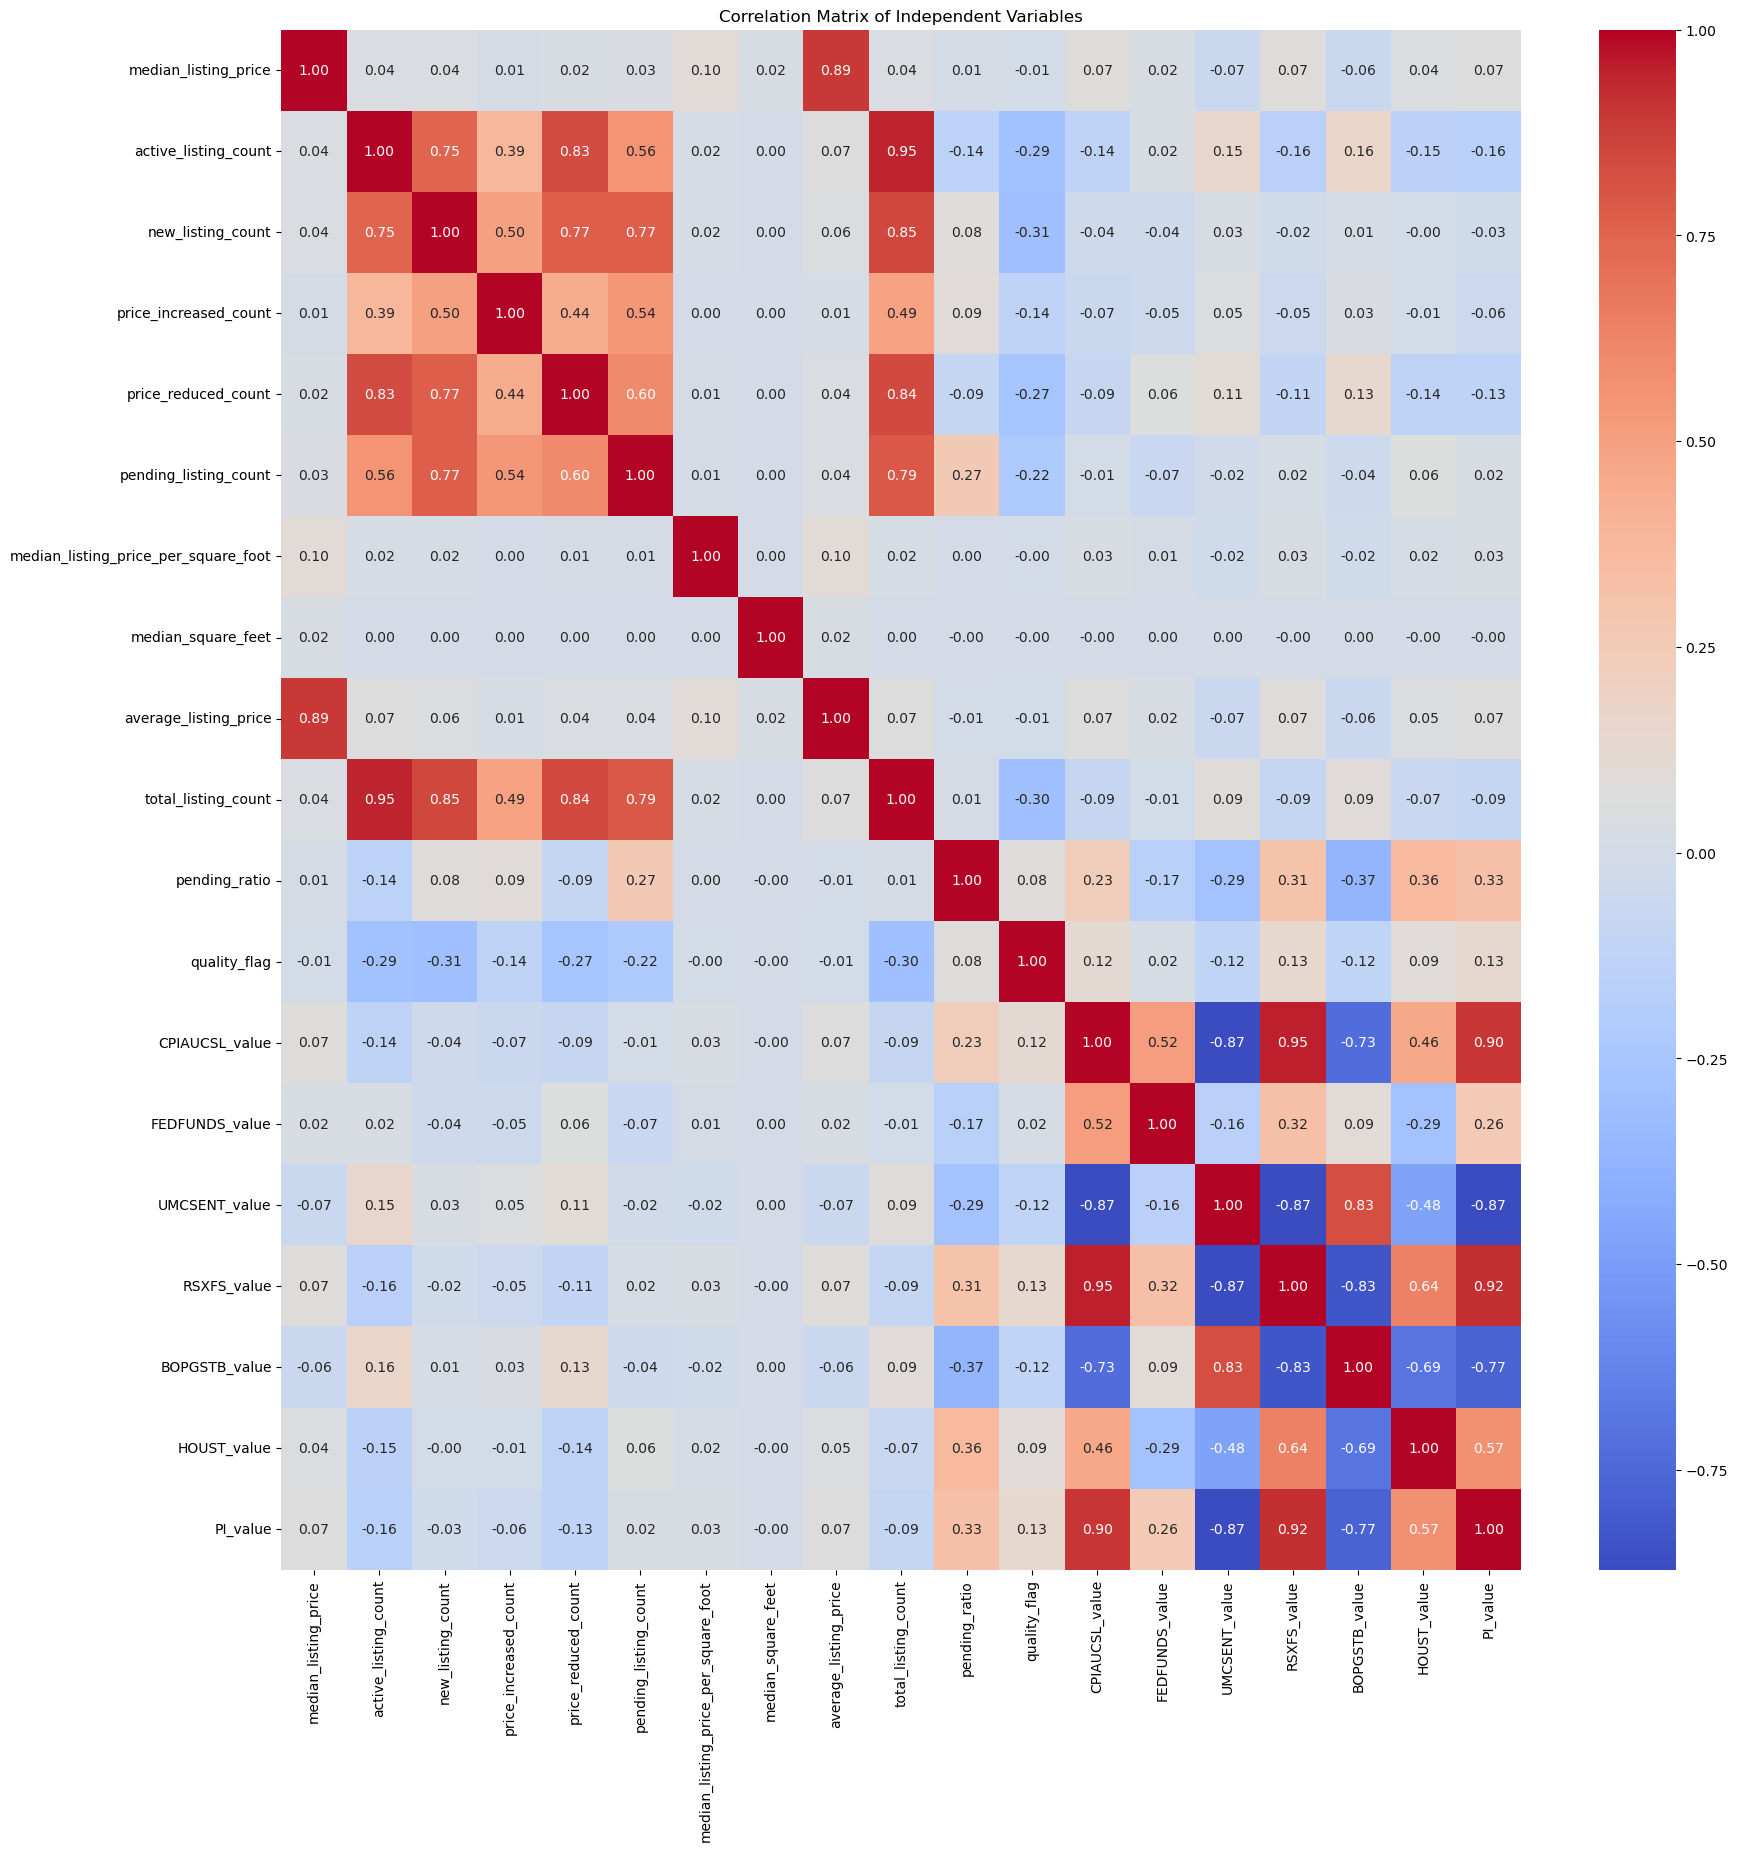

In [4]:
#perform train, test, split, plot corr plot
train_set_x = train_set.drop('median_days_on_market', axis=1)
train_set_y = train_set['median_days_on_market']

val_set_x = validation_set.drop('median_days_on_market', axis=1)
val_set_y = validation_set['median_days_on_market']

test_set_x = test_set.drop('median_days_on_market', axis=1)
test_set_y = test_set['median_days_on_market']

corr_matrix = train_set_x.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Independent Variables')
plt.show()

In [5]:
# multicollinearity check

threshold = 0.85

highly_correlated_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            highly_correlated_pairs.append((colname_i, colname_j))


highly_correlated_pairs

[('average_listing_price', 'median_listing_price'),
 ('total_listing_count', 'active_listing_count'),
 ('total_listing_count', 'new_listing_count'),
 ('UMCSENT_value', 'CPIAUCSL_value'),
 ('RSXFS_value', 'CPIAUCSL_value'),
 ('RSXFS_value', 'UMCSENT_value'),
 ('PI_value', 'CPIAUCSL_value'),
 ('PI_value', 'UMCSENT_value'),
 ('PI_value', 'RSXFS_value')]

### Because we are more worried about the predictive power of our regression model, I am less concerned about the multicolinearity. This is why the Threshold was kept at 0.85. 

### Now to choose the independent variables to remove:

### - average_listing_price (median listing price would be a better indicator)
### - total_listing_count (active_listing_count would be a better fit)
### - will remove RSXFS_value, CPIAUCSL_value and PI

### - quality_flag will be removed too as it is a binary column denoting whether the row data falls within an "normal range" added by Realtor.com. 

In [6]:
#remove cols, re instantiate training sets
cols_to_remove = ['average_listing_price', 'total_listing_count','quality_flag' ,'RSXFS_value','CPIAUCSL_value','PI_value']

train_set_x = train_set_x.drop(cols_to_remove, axis=1)

val_set_x = val_set_x.drop(cols_to_remove, axis=1)

test_set_x = test_set_x.drop(cols_to_remove, axis=1)

In [7]:
# Begin with basic linear regression on the remaining variables

X = train_set_x
y = train_set['median_days_on_market']


X = sm.add_constant(X)

model_a = sm.OLS(y, X).fit()

model_summary = model_a.summary()
print(model_summary)

                              OLS Regression Results                             
Dep. Variable:     median_days_on_market   R-squared:                       0.146
Model:                               OLS   Adj. R-squared:                  0.146
Method:                    Least Squares   F-statistic:                 1.604e+04
Date:                   Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                           20:56:10   Log-Likelihood:            -6.4282e+06
No. Observations:                1217078   AIC:                         1.286e+07
Df Residuals:                    1217064   BIC:                         1.286e+07
Df Model:                             13                                         
Covariance Type:               nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [8]:
#get MSE and R^2 on validation set for basic regression
val_regress = val_set_x
val_regress = sm.add_constant(val_regress)
val_regress_pred = model_a.predict(val_regress)

regress_mse = mean_squared_error(validation_set['median_days_on_market'], val_regress_pred)
regress_r2 = r2_score(validation_set['median_days_on_market'], val_regress_pred)
print("Mean Square Error for Multivariate Regression Model")
print(regress_mse)
print("R^2 for Multivariate Regression Model")
print(regress_r2)

Mean Square Error for Multivariate Regression Model
2265.6916780863567
R^2 for Multivariate Regression Model
0.14745891581515846


In [9]:
# next we attempt a log transform on the data
independent_vars = train_set_x.columns

for var in independent_vars:
    min_val = train_set_x[var].min()
    shift = np.abs(min_val) + 1
    train_set_x[f'ln_{var}'] = np.log(train_set_x[var] + shift)
    
    min_val = val_set_x[var].min()
    shift = np.abs(min_val) + 1
    val_set_x[f'ln_{var}'] = np.log(val_set_x[var] + shift)
    
    min_val = test_set_x[var].min()
    shift = np.abs(min_val) + 1
    test_set_x[f'ln_{var}'] = np.log(test_set_x[var] + shift)

X = train_set_x[[f'ln_{var}' for var in independent_vars]] 
y = np.log(train_set['median_days_on_market'] + 1)

X = sm.add_constant(X)

model_b = sm.OLS(y, X).fit()

model_summary = model_b.summary()
print(model_summary)

                              OLS Regression Results                             
Dep. Variable:     median_days_on_market   R-squared:                       0.299
Model:                               OLS   Adj. R-squared:                  0.299
Method:                    Least Squares   F-statistic:                 4.002e+04
Date:                   Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                           20:56:11   Log-Likelihood:            -1.1259e+06
No. Observations:                1217078   AIC:                         2.252e+06
Df Residuals:                    1217064   BIC:                         2.252e+06
Df Model:                             13                                         
Covariance Type:               nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [10]:
#create version of x datasets without any log transformed data 
train_set_x_nolog = train_set_x.iloc[: , :13]
val_set_x_nolog = val_set_x.iloc[: , :13]
test_set_x_nolog = test_set_x.iloc[: , :13]
train_set_x_nolog

,median_listing_price,active_listing_count,new_listing_count,price_increased_count,price_reduced_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,pending_ratio,FEDFUNDS_value,UMCSENT_value,BOPGSTB_value,HOUST_value
685530,218000.0,9.0,4.0,0.0,0.0,2.000000,179.0,1564.0,0.235300,0.09,70.3,-71816.0,1576.0
1079068,177000.0,16.0,0.0,0.0,0.0,22.587914,163.0,1265.0,0.852213,0.05,72.3,-54700.0,1054.0
1432251,2294055.0,1.0,0.0,0.0,0.0,1.000000,212.0,9290.0,1.000000,2.42,97.2,-49433.0,1267.0
526760,1295000.0,1.0,0.0,0.0,0.0,1.000000,370.0,3500.0,1.000000,0.08,62.8,-86960.0,1771.0
1729792,32950.0,4.0,2.0,0.0,0.0,17.815036,33.0,886.0,0.415974,1.70,98.0,-41421.0,1357.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
482874,1950000.0,1.0,0.0,0.0,0.0,19.952811,867.0,2250.0,1.086538,0.20,59.4,-102536.0,1713.0
425830,149900.0,1.0,0.0,0.0,0.0,1.000000,95.0,1582.0,1.000000,1.21,50.0,-80851.0,1561.0
92953,927450.0,24.0,8.0,0.0,8.0,6.000000,754.0,1260.0,0.250000,5.08,64.2,-63718.0,1418.0
166013,576500.0,3.0,6.0,0.0,0.0,5.000000,266.0,2273.0,1.500000,4.65,62.0,-60403.0,1380.0


In [11]:
#get MSE and R^2 on validation set for log regression
val_log_regress = val_set_x[[f'ln_{var}' for var in independent_vars]] 
val_log_regress = sm.add_constant(val_log_regress)
pred_log_regress = model_b.predict(val_log_regress)

mse_logreg = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), pred_log_regress)
r2_logreg = r2_score(np.log(validation_set['median_days_on_market'] + 1), pred_log_regress)

print("Mean Square Error for Multivariate Regression Model")
print(mse_logreg)
print("R^2 for Multivariate Regression Model")
print(r2_logreg)

Mean Square Error for Multivariate Regression Model
0.37147067062202516
R^2 for Multivariate Regression Model
0.30212102142202113


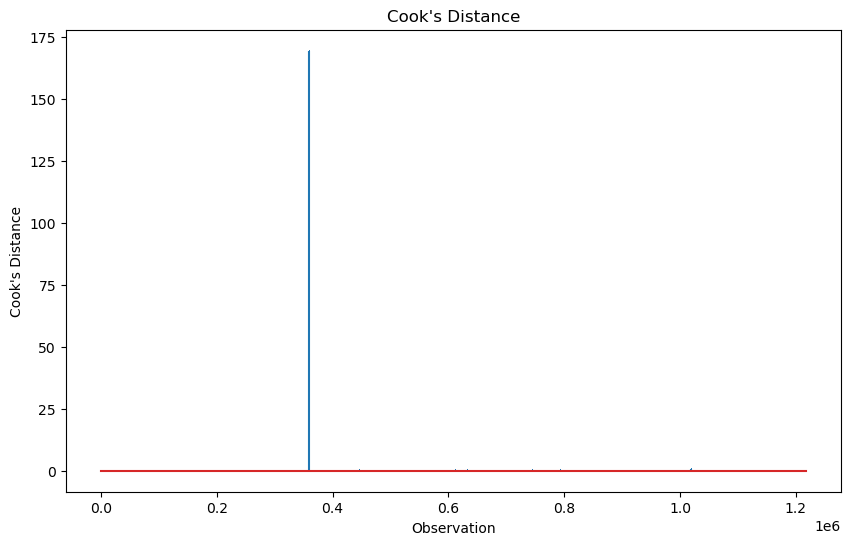

In [12]:
# let's see if there are outliers

influence = model_a.get_influence()

cooks = influence.cooks_distance[0]

n = len(train_set_x)

THRESH = 4/n


outliers = np.where(cooks > THRESH)[0]


plt.figure(figsize=(10,6))
plt.stem(np.arange(len(cooks)), cooks, markerfmt=",")
#plt.axhline(y=threshold, color='r', linestyle='--')
plt.title("Cook's Distance")
plt.xlabel("Observation")
plt.ylabel("Cook's Distance")
plt.show()

In [13]:
max(cooks)

169.34868498593522

In [14]:
len(train_set_x)

1217078

In [15]:
train_set_x = train_set_x.drop(train_set_x.index[outliers])
train_set_y = train_set_y.drop(train_set_y.index[outliers])
train_set_x_nolog = train_set_x_nolog.drop(train_set_x_nolog.index[outliers])
train_set = train_set.drop(train_set.index[outliers])
train_set_x

,median_listing_price,active_listing_count,new_listing_count,price_increased_count,price_reduced_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,pending_ratio,FEDFUNDS_value,...,ln_price_increased_count,ln_price_reduced_count,ln_pending_listing_count,ln_median_listing_price_per_square_foot,ln_median_square_feet,ln_pending_ratio,ln_FEDFUNDS_value,ln_UMCSENT_value,ln_BOPGSTB_value,ln_HOUST_value
685530,218000.0,9.0,4.0,0.0,0.0,2.000000,179.0,1564.0,0.235300,0.09,...,0.0,0.000000,1.098612,5.192957,7.356280,0.211314,0.131028,4.798267,10.332702,7.824846
1079068,177000.0,16.0,0.0,0.0,0.0,22.587914,163.0,1265.0,0.852213,0.05,...,0.0,0.000000,3.160734,5.099866,7.144407,0.616381,0.095310,4.814620,10.775555,7.590852
1432251,2294055.0,1.0,0.0,0.0,0.0,1.000000,212.0,9290.0,1.000000,2.42,...,0.0,0.000000,0.693147,5.361292,9.136909,0.693147,1.244155,4.998563,10.880008,7.693026
1729792,32950.0,4.0,2.0,0.0,0.0,17.815036,33.0,886.0,0.415974,1.70,...,0.0,0.000000,2.934656,3.526361,6.788972,0.347818,1.011601,5.003946,11.020529,7.733246
1579972,1600000.0,1.0,0.0,0.0,0.0,17.815036,680.0,2352.0,0.415974,2.20,...,0.0,0.000000,2.934656,6.523562,7.763871,0.347818,1.178655,5.000585,10.880610,7.653020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198630,125000.0,1.0,0.0,0.0,0.0,22.587914,119.0,1048.0,0.852213,1.55,...,0.0,0.000000,3.160734,4.787492,6.956545,0.616381,0.955511,5.015954,10.978268,7.823246
168594,412975.0,14.0,8.0,0.0,4.0,15.000000,239.0,1871.0,1.035700,4.65,...,0.0,1.609438,2.772589,5.480639,7.535297,0.710840,1.740466,4.727388,10.648610,7.743270
92953,927450.0,24.0,8.0,0.0,8.0,6.000000,754.0,1260.0,0.250000,5.08,...,0.0,2.197225,1.945910,6.626718,7.140453,0.223144,1.813195,4.746670,10.566665,7.759614
166013,576500.0,3.0,6.0,0.0,0.0,5.000000,266.0,2273.0,1.500000,4.65,...,0.0,0.000000,1.791759,5.587249,7.729735,0.916291,1.740466,4.727388,10.648610,7.743270


### A little more than 38,000 observations were deemed outliers based on the threshold and removed from the training data. Including one observation that yielded a cooks distance of 169.34, no other observations yielded a cooks distance greater than 1. 

In [16]:
#run log reg again on new train set
X = train_set_x[[f'ln_{var}' for var in independent_vars]] 
y = np.log(train_set['median_days_on_market'] + 1)

X = sm.add_constant(X)

model_c = sm.OLS(y, X).fit()

model_summary = model_c.summary()
print(model_summary)

                              OLS Regression Results                             
Dep. Variable:     median_days_on_market   R-squared:                       0.326
Model:                               OLS   Adj. R-squared:                  0.326
Method:                    Least Squares   F-statistic:                 4.382e+04
Date:                   Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                           20:56:24   Log-Likelihood:            -1.0250e+06
No. Observations:                1179917   AIC:                         2.050e+06
Df Residuals:                    1179903   BIC:                         2.050e+06
Df Model:                             13                                         
Covariance Type:               nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [17]:
val_log_regress_cooks = val_set_x[[f'ln_{var}' for var in independent_vars]] 
val_log_regress_cooks = sm.add_constant(val_log_regress_cooks)
pred_log_regress_cooks = model_c.predict(val_log_regress_cooks)

mse_logreg_cooks = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), pred_log_regress_cooks)
r2_logreg_cooks = r2_score(np.log(validation_set['median_days_on_market'] + 1), pred_log_regress_cooks)
print("Mean Square Error for Log Reg Model w/ outliers removed")
print(mse_logreg_cooks)
print("R^2 for Log Reg Model w/ outliers removed")
print(r2_logreg_cooks)

Mean Square Error for Log Reg Model w/ outliers removed
0.374430855836501
R^2 for Log Reg Model w/ outliers removed
0.2965597451295462


### The removal of outliers surpisingly looks to yield a marginally worse model. Next we will try Ridge and Lasso regularization techniques.

In [18]:
alphas = (0.05,0.5,2,5,10,100)
#ridge regression on log transformed data 
ridge_cv_non_scaled = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv_non_scaled.fit(train_set_x[[f'ln_{var}' for var in independent_vars]], 
                        np.log(train_set['median_days_on_market'] + 1))

RidgeCV(alphas=(0.05, 0.5, 2, 5, 10, 100), store_cv_values=True)

In [19]:
# Lasso Regression with Cross-Validation on log transformed data
lasso_cv_non_scaled = LassoCV(alphas=alphas, cv=5)
lasso_cv_non_scaled.fit(train_set_x[[f'ln_{var}' for var in independent_vars]], 
                        np.log(train_set['median_days_on_market'] + 1))

LassoCV(alphas=(0.05, 0.5, 2, 5, 10, 100), cv=5)

In [20]:
ridge_val_pred_non_scaled = ridge_cv_non_scaled.predict(val_set_x[[f'ln_{var}' for var in independent_vars]])
ridge_val_mse_non_scaled = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), 
                                           ridge_val_pred_non_scaled)
print("Ridge Regression MSE on Validation Set - log transformed not scaled:", ridge_val_mse_non_scaled)
print("Best Ridge alpha:", ridge_cv_non_scaled.alpha_)

ridge_non_scaled_r2 = r2_score(np.log(validation_set['median_days_on_market'] + 1), ridge_val_pred_non_scaled)
print("Ridge R-squared non scaled:", ridge_non_scaled_r2)


lasso_val_pred_non_scaled = lasso_cv_non_scaled.predict(val_set_x[[f'ln_{var}' for var in independent_vars]])
lasso_val_mse_non_scaled = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), 
                                           lasso_val_pred_non_scaled)
print("Lasso Regression MSE on Validation Set - log transformed not scaled:", lasso_val_mse_non_scaled)
print("Best Lasso alpha:", lasso_cv_non_scaled.alpha_)
lasso_non_scaled_r2 = r2_score(np.log(validation_set['median_days_on_market'] + 1), lasso_val_pred_non_scaled)
print("Lasso R-squared non scaled:", lasso_non_scaled_r2)

Ridge Regression MSE on Validation Set - log transformed not scaled: 0.3744306105626176
Best Ridge alpha: 10.0
Ridge R-squared non scaled: 0.29656020592362964
Lasso Regression MSE on Validation Set - log transformed not scaled: 0.39614080939258417
Best Lasso alpha: 0.05
Lasso R-squared non scaled: 0.2557734289788671


In [21]:
# lasso and ridge regularization on independent variables using scaler on log transformed data
# instantiate scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_set_x[[f'ln_{var}' for var in independent_vars]])
X_val_scaled = scaler.transform(val_set_x[[f'ln_{var}' for var in independent_vars]])
X_test_scaled = scaler.transform(test_set_x[[f'ln_{var}' for var in independent_vars]])

In [22]:
alphas = np.logspace(-5, 5, 100)

# Ridge Regression with Cross-Validation on scaled, log transformed data
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train_scaled, np.log(train_set['median_days_on_market'] + 1))

# Lasso Regression with Cross-Validation on scaled, log transformed data
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train_scaled, np.log(train_set['median_days_on_market'] + 1))

LassoCV(alphas=array([1.00000000e-05, 1.26185688e-05, 1.59228279e-05, 2.00923300e-05,
       2.53536449e-05, 3.19926714e-05, 4.03701726e-05, 5.09413801e-05,
       6.42807312e-05, 8.11130831e-05, 1.02353102e-04, 1.29154967e-04,
       1.62975083e-04, 2.05651231e-04, 2.59502421e-04, 3.27454916e-04,
       4.13201240e-04, 5.21400829e-04, 6.57933225e-04, 8.30217568e-04,
       1.04761575e-03, 1.32194115e-0...
       4.75081016e+02, 5.99484250e+02, 7.56463328e+02, 9.54548457e+02,
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05]),
        cv=5)

In [23]:
ridge_val_pred_scaled = ridge_cv.predict(X_val_scaled)
ridge_val_mse_scaled = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), ridge_val_pred_scaled)
print("Ridge Regression MSE on Validation Set:", ridge_val_mse_scaled)


lasso_val_pred_scaled = lasso_cv.predict(X_val_scaled)
lasso_val_mse_scaled = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), lasso_val_pred_scaled)
print("Lasso Regression MSE on Validation Set:", lasso_val_mse_scaled)


print("Best Ridge alpha:", ridge_cv.alpha_)
print("Best Lasso alpha:", lasso_cv.alpha_)

Ridge Regression MSE on Validation Set: 0.37443078432542404
Lasso Regression MSE on Validation Set: 0.3744300026073627
Best Ridge alpha: 3.593813663804626
Best Lasso alpha: 1e-05


In [24]:
ridge_predictions = ridge_cv.predict(X_val_scaled)
lasso_predictions = lasso_cv.predict(X_val_scaled)

# Calculate R-squared
ridge_r2 = r2_score(np.log(validation_set['median_days_on_market'] + 1), ridge_predictions)
lasso_r2 = r2_score(np.log(validation_set['median_days_on_market'] + 1), lasso_predictions)

print("Ridge R-squared on Validation Set:", ridge_r2)
print("Lasso R-squared on Validation Set:", lasso_r2)

Ridge R-squared on Validation Set: 0.2965598794768347
Lasso R-squared on Validation Set: 0.2965613480843058


### Based on the combination of the above model MSEs and the R-Squared values, the log log regression models seems to yield the best model results, with the Ridge regularized log regression model yiedling very similar results. Preceding models will be created with non scaled input data, scaled input data, and log transformed input data. 

## Random Forest Model

In [25]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import sqlite3
import logging
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import itertools
import statsmodels.api as sm
from multiprocessing import Pool
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [26]:
# creating random forest model on non scaled data
rf_model = RandomForestRegressor(n_estimators=50, random_state=random.randint(1,100))  

rf_model.fit(train_set_x_nolog, train_set_y)

RandomForestRegressor(n_estimators=50, random_state=2)

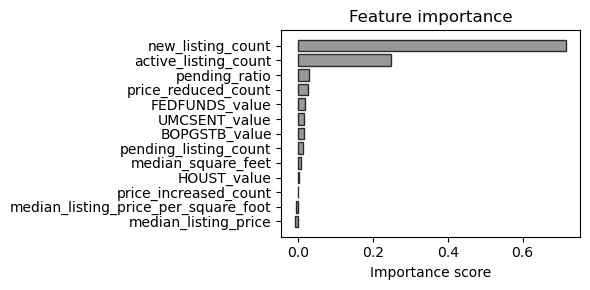

In [27]:
# first we'll take a look at feature importance 
from sklearn.ensemble import RandomForestRegressor
import rfpimp

############################### Permutation feature importance #####################################

imp = rfpimp.importances(rf_model, val_set_x_nolog, val_set_y)

############################################## Plot ################################################

fig, ax = plt.subplots(figsize=(6, 3))

ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k')
ax.set_xlabel('Importance score')
ax.set_title('Feature importance')
plt.gca().invert_yaxis()

fig.tight_layout()

### New listing count appears to posess the largest feature importance by a significant margin, with the median square feet being ths smallest. 

In [28]:
# see mse and r2 results of initial RF model
rf_pred = rf_model.predict(val_set_x_nolog)

rf_mse = mean_squared_error(val_set_y, rf_pred)
rf_r2 = r2_score(val_set_y, rf_pred)
print("Mean Square Error for Random Forest Model using unscaled data")
print(rf_mse)
print("R^2 for Random Forest Model using unscaled data")
print(rf_r2)

Mean Square Error for Random Forest Model using unscaled data
1939.5875449279936
R^2 for Random Forest Model using unscaled data
0.2701663318016122


In [29]:
#now attempting to scale the data and re run RF

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_set_x_nolog)
X_val_scaled = scaler.transform(val_set_x_nolog)
X_test_scaled = scaler.transform(test_set_x_nolog)

#series to df for scaler
train_set_y = pd.DataFrame(train_set_y)
val_set_y = pd.DataFrame(val_set_y)
test_set_y = pd.DataFrame(test_set_y)

Y_train_scaled = scaler.fit_transform(train_set_y)
Y_val_scaled = scaler.transform(val_set_y)
Y_test_scaled = scaler.transform(test_set_y)
len(X_train_scaled)

1179917

In [30]:
# creating random forest model on scaled data
rf_model_scaled = RandomForestRegressor(n_estimators=50, random_state=random.randint(1,100))  

rf_model_scaled.fit(X_train_scaled, Y_train_scaled)

/Users/erikeuler/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(n_estimators=50, random_state=24)

In [31]:

rf_pred_scaled = rf_model_scaled.predict(X_val_scaled)

rf_mse_scaled = mean_squared_error(Y_val_scaled, rf_pred_scaled)
rf_r2_scaled = r2_score(Y_val_scaled, rf_pred_scaled)
print("Mean Square Error for Random Forest Model on scaled data")
print(rf_mse_scaled)
print("R^2 for Random Forest Model on scaled data")
print(rf_r2_scaled)

Mean Square Error for Random Forest Model on scaled data
1.032474622744188
R^2 for Random Forest Model on scaled data
0.27001737482799193


In [32]:
# creating random forest model on log transformed data
rf_log_model = RandomForestRegressor(n_estimators=50, random_state=random.randint(1,100))  

rf_log_model.fit(train_set_x[[f'ln_{var}' for var in independent_vars]], np.log(train_set['median_days_on_market'] + 1))

RandomForestRegressor(n_estimators=50, random_state=83)

In [33]:
rf_log_pred = rf_log_model.predict(val_set_x[[f'ln_{var}' for var in independent_vars]])

rf_log_mse = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), rf_log_pred)
rf_log_r2 = r2_score(np.log(validation_set['median_days_on_market'] + 1), rf_log_pred)
print("Mean Square Error for Random Forest Model using log transformed data")
print(rf_log_mse)
print("R^2 for Random Forest Model using log transformed data")
print(rf_log_r2)

Mean Square Error for Random Forest Model using log transformed data
0.33402263215011097
R^2 for Random Forest Model using log transformed data
0.3724743518606445


## ANN

In [34]:
import pandas as pd
import numpy as np
import sqlite3
import logging
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import logging


In [35]:
print("TensorFlow Version:", tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

tf.test.gpu_device_name()

print("Available GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.12.0
Num GPUs Available:  0
Available GPU devices: []


In [36]:
#create ANN model on Non Scaled data
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(train_set_x_nolog.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear')) 


model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(train_set_x_nolog, train_set_y, validation_data=(val_set_x_nolog, val_set_y), epochs=50, batch_size=32)


val_loss = model.evaluate(val_set_x_nolog, val_set_y)
#test_loss = model.evaluate(test_set_x, test_set_y)

print("Validation Loss:", val_loss)
#print("Test Loss:", test_loss)

Epoch 1/50


2023-12-01 21:17:07.994000: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


36873/36873 [==============================] - 17s 468us/step - loss: 3123963.7500 - val_loss: 186635.5625
Epoch 2/50
36873/36873 [==============================] - 17s 466us/step - loss: 4478.7739 - val_loss: 18135.1973
Epoch 3/50
36873/36873 [==============================] - 17s 471us/step - loss: 2180.8313 - val_loss: 2873.1533
Epoch 4/50
36873/36873 [==============================] - 17s 473us/step - loss: 1879.7571 - val_loss: 2844.8867
Epoch 5/50
36873/36873 [==============================] - 17s 471us/step - loss: 1878.9706 - val_loss: 2844.7136
Epoch 6/50
36873/36873 [==============================] - 17s 468us/step - loss: 1878.9667 - val_loss: 2844.9736
Epoch 7/50
36873/36873 [==============================] - 17s 471us/step - loss: 1878.9656 - val_loss: 2845.5439
Epoch 8/50
36873/36873 [==============================] - 17s 468us/step - loss: 1878.9725 - val_loss: 2844.5488
Epoch 9/50
36873/36873 [==============================] - 17s 473us/step - loss: 1878.9778 - val_loss

In [37]:
pred_ann_nonscale = model.predict(val_set_x_nolog)

ann_mse = mean_squared_error(val_set_y, pred_ann_nonscale)
ann_r2 = r2_score(val_set_y, pred_ann_nonscale)
print("Mean Square Error for vanilla ANN Model - Non Scaled data")
print(ann_mse)
print("R^2 for vanilla ANN Model - Non Scaled data")
print(ann_r2)

12678/12678 [==============================] - 3s 250us/step
Mean Square Error for vanilla ANN Model - Non Scaled data
2844.721530250974
R^2 for vanilla ANN Model - Non Scaled data
-0.07042012867899516


In [38]:
#FUNCTION TO ITERATE AND FIND BEST POSSIBLE ANN ON non SCALED DATA
# def build_model_nonscale(hp):
#     model = keras.Sequential()
#     model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), 
#                            activation='relu', input_shape=(train_set_x_nolog.shape[1],)))
#     model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
#     model.add(layers.Dense(1, activation='linear'))  # Output layer for regression

#     model.compile(optimizer=keras.optimizers.Adam(
#         hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
#         loss='mean_squared_error')
    
#     return model

# tuner_nonscale = kt.RandomSearch(
#     build_model_nonscale,
#     objective='val_loss',
#     max_trials=10,
#     executions_per_trial=1,
#     directory='my_dir',
#     project_name='ann_regression'
# )

#tuner_nonscale.search(train_set_x_nolog, train_set_y, epochs=20, validation_data=(val_set_x_nolog, val_set_y))

# Get the best hyperparameters
#best_hps = tuner_nonscale.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
#best_model = build_model_nonscale(best_hps)

# Fit the best model
#history = best_model.fit(train_set_x_nolog, train_set_y, epochs=20, validation_data=(val_set_x_nolog, val_set_y))

# Evaluate on the test set
#test_loss = best_model.evaluate(test_set_x, test_set_y)
#print("Test Loss:", test_loss)

# Evaluate on the test set
#test_loss = best_model.evaluate(test_set_x, test_set_y)
#print("Test Loss:", test_loss)

In [39]:
#create new ANN model on scaled data

#instantiate model
model_scaled = Sequential()
model_scaled.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model_scaled.add(Dense(32, activation='relu'))
model_scaled.add(Dense(1, activation='linear')) 


model_scaled.compile(optimizer='adam', loss='mean_squared_error')
#fit data 
history_scaled = model_scaled.fit(X_train_scaled, Y_train_scaled, validation_data=(X_val_scaled, Y_val_scaled), epochs=50, batch_size=32)

#evaluate using MSE as loss function
val_loss_scaled = model_scaled.evaluate(X_val_scaled, Y_val_scaled)
#test_loss_scaled = model_scaled.evaluate(X_test_scaled, Y_test_scaled)

print("Validation Loss:", val_loss_scaled)
#print("Test Loss:", test_loss_scaled)



Epoch 1/50
36873/36873 [==============================] - 18s 478us/step - loss: 0.6969 - val_loss: 1.1050
Epoch 2/50
36873/36873 [==============================] - 18s 482us/step - loss: 0.6673 - val_loss: 1.0509
Epoch 3/50
36873/36873 [==============================] - 18s 496us/step - loss: 0.6610 - val_loss: 1.0444
Epoch 4/50
36873/36873 [==============================] - 18s 486us/step - loss: 0.6568 - val_loss: 1.0221
Epoch 5/50
36873/36873 [==============================] - 17s 464us/step - loss: 0.6545 - val_loss: 1.0406
Epoch 6/50
36873/36873 [==============================] - 18s 484us/step - loss: 0.6524 - val_loss: 1.0397
Epoch 7/50
36873/36873 [==============================] - 17s 471us/step - loss: 0.6508 - val_loss: 1.0286
Epoch 8/50
36873/36873 [==============================] - 17s 469us/step - loss: 0.6500 - val_loss: 1.0233
Epoch 9/50
36873/36873 [==============================] - 17s 464us/step - loss: 0.6487 - val_loss: 1.0246
Epoch 10/50
36873/36873 [============

In [40]:
#see r2 and MSE of inital ann on scaled data
pred_ann_scaled = model_scaled.predict(X_val_scaled)

ann_mse_scaled = mean_squared_error(Y_val_scaled, pred_ann_scaled)
ann_r2_scaled = r2_score(Y_val_scaled, pred_ann_scaled)
print("Mean Square Error for vanilla ANN Model - scaled data")
print(ann_mse_scaled)
print("R2 for vanilla ANN Model - scaled data")
print(ann_r2_scaled)

12678/12678 [==============================] - 3s 227us/step
Mean Square Error for vanilla ANN Model - scaled data
1.038013702736251
R2 for vanilla ANN Model - scaled data
0.26610112152299836


In [41]:
#FUNCTION TO ITERATE AND FIND BEST POSSIBLE ANN ON SCALED DATA
# def build_model_scaled(hp):
#     model = keras.Sequential()
#     model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), 
#                            activation='relu', input_shape=(X_train_scaled.shape[1],)))
#     model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
#     model.add(layers.Dense(1, activation='linear'))  # Output layer for regression

#     model.compile(optimizer=keras.optimizers.Adam(
#         hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
#         loss='mean_squared_error')
    
#     return model

# tuner_scaled = kt.RandomSearch(
#     build_model_scaled,
#     objective='val_loss',
#     max_trials=10,
#     executions_per_trial=1,
#     directory='my_dir',
#     project_name='ann_regression'
# )

#tuner_scaled.search(X_train_scaled, Y_train_scaled, epochs=20, validation_data=(X_val_scaled, Y_val_scaled))

# Get the best hyperparameters
#best_hps_scaled = tuner_scaled.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
#best_model_scaled = build_model_scaled(best_hps_scaled)

# Fit the best model
#history_scaled = best_model_scaled.fit(X_train_scaled, Y_train_scaled, epochs=20, validation_data=(X_val_scaled, Y_val_scaled))

# Evaluate on the test set
#test_loss_scaled = best_model_scaled.evaluate(X_test_scaled, Y_test_scaled)
#print("Test Loss:", test_loss_scaled)

In [42]:
#create new ANN model on log transformed data

#instantiate model
model_log = Sequential()
model_log.add(Dense(64, activation='relu', input_shape=(train_set_x[[f'ln_{var}' for var in independent_vars]].shape[1],)))
model_log.add(Dense(32, activation='relu'))
model_log.add(Dense(1, activation='linear')) 


model_log.compile(optimizer='adam', loss='mean_squared_error')
#fit data 
history_log = model_log.fit(train_set_x[[f'ln_{var}' for var in independent_vars]], pd.DataFrame(np.log(train_set['median_days_on_market'] + 1)), validation_data=(val_set_x[[f'ln_{var}' for var in independent_vars]], pd.DataFrame(np.log(validation_set['median_days_on_market'] + 1))), epochs=50, batch_size=32)

#evaluate using MSE as loss function
val_loss_log = model_log.evaluate(val_set_x[[f'ln_{var}' for var in independent_vars]], np.log(validation_set['median_days_on_market'] + 1))
#test_loss_log = model_log.evaluate(X_test_scaled, Y_test_scaled)

print("Validation Loss:", val_loss_log)
#print("Test Loss:", test_loss_log)

Epoch 1/50
36873/36873 [==============================] - 17s 464us/step - loss: 0.3165 - val_loss: 0.3354
Epoch 2/50
36873/36873 [==============================] - 17s 472us/step - loss: 0.2982 - val_loss: 0.3311
Epoch 3/50
36873/36873 [==============================] - 17s 462us/step - loss: 0.2962 - val_loss: 0.3340
Epoch 4/50
36873/36873 [==============================] - 17s 465us/step - loss: 0.2952 - val_loss: 0.3328
Epoch 5/50
36873/36873 [==============================] - 17s 462us/step - loss: 0.2943 - val_loss: 0.3352
Epoch 6/50
36873/36873 [==============================] - 17s 464us/step - loss: 0.2938 - val_loss: 0.3298
Epoch 7/50
36873/36873 [==============================] - 17s 464us/step - loss: 0.2932 - val_loss: 0.3387
Epoch 8/50
36873/36873 [==============================] - 17s 464us/step - loss: 0.2927 - val_loss: 0.3358
Epoch 9/50
36873/36873 [==============================] - 17s 462us/step - loss: 0.2925 - val_loss: 0.3307
Epoch 10/50
36873/36873 [============

In [43]:
pred_ann_logt = model_log.predict(val_set_x[[f'ln_{var}' for var in independent_vars]])

ann_mse_logt = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), pred_ann_logt)
ann_r2_logt = r2_score(np.log(validation_set['median_days_on_market'] + 1), pred_ann_logt)
print('test')
print("Mean Square Error for vanilla ANN Model - log transformed data")
print(ann_mse_logt)
print("R2 for vanilla ANN Model - log transformed data")
print(ann_r2_logt)

12678/12678 [==============================] - 3s 247us/step
test
Mean Square Error for vanilla ANN Model - log transformed data
0.33419186843234405
R2 for vanilla ANN Model - log transformed data
0.37215640901044467


### The ANN model on log transformed data looks to yield the highest R2 in comparison to the other two ANN models created. The function below will optimize the ANN model on this log transformed data.

In [71]:
def build_model_logt(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), 
                           activation='relu', input_shape=(train_set_x[[f'ln_{var}' for var in independent_vars]].shape[1],)))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))  # Output layer for regression

    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error')
    
    return model

tuner_logt = kt.RandomSearch(
    build_model_logt,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='ann_regression'
)

tuner_logt.search(train_set_x[[f'ln_{var}' for var in independent_vars]], np.log(train_set['median_days_on_market'] + 1), epochs=20, validation_data=(val_set_x[[f'ln_{var}' for var in independent_vars]], np.log(validation_set['median_days_on_market'] + 1)))

# Get the best hyperparameters
best_hps_logt = tuner_logt.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model_logt = build_model_logt(best_hps_logt)

# Fit the best model
history_logt = best_model_logt.fit(train_set_x[[f'ln_{var}' for var in independent_vars]], np.log(train_set['median_days_on_market'] + 1),epochs=20, 
                  validation_data=(val_set_x[[f'ln_{var}' for var in independent_vars]], np.log(validation_set['median_days_on_market'] + 1)))

# Evaluate on the test set
#test_loss_logt = best_model_logt.evaluate(X_test_scaled, Y_test_scaled)
#print("Test Loss:", test_loss_scaled)

Trial 5 Complete [00h 05m 46s]
val_loss: 0.3352823555469513

Best val_loss So Far: 0.3265228867530823
Total elapsed time: 01h 20m 51s
Epoch 1/20
36873/36873 [==============================] - 22s 581us/step - loss: 0.3730 - val_loss: 0.3401
Epoch 2/20
36873/36873 [==============================] - 22s 591us/step - loss: 0.3119 - val_loss: 0.3399
Epoch 3/20
36873/36873 [==============================] - 21s 576us/step - loss: 0.3071 - val_loss: 0.3470
Epoch 4/20
36873/36873 [==============================] - 21s 574us/step - loss: 0.3049 - val_loss: 0.3313
Epoch 5/20
36873/36873 [==============================] - 21s 577us/step - loss: 0.3039 - val_loss: 0.3288
Epoch 6/20
36873/36873 [==============================] - 21s 577us/step - loss: 0.3029 - val_loss: 0.3274
Epoch 7/20
36873/36873 [==============================] - 21s 577us/step - loss: 0.3020 - val_loss: 0.3344
Epoch 8/20
36873/36873 [==============================] - 21s 578us/step - loss: 0.3016 - val_loss: 0.3358
Epoch 9/20

In [72]:
pred_ann_logt = best_model_logt.predict(val_set_x[[f'ln_{var}' for var in independent_vars]])

ann_mse_logt = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), pred_ann_logt)
ann_r2_logt = r2_score(np.log(validation_set['median_days_on_market'] + 1), pred_ann_logt)
print("Mean Square Error for vanilla ANN Model - log transformed data")
print(ann_mse_logt)
print("R2 for vanilla ANN Model - log transformed data")
print(ann_r2_logt)

12678/12678 [==============================] - 3s 249us/step
Mean Square Error for vanilla ANN Model - log transformed data
0.33009285095322083
R2 for vanilla ANN Model - log transformed data
0.3798572003722869


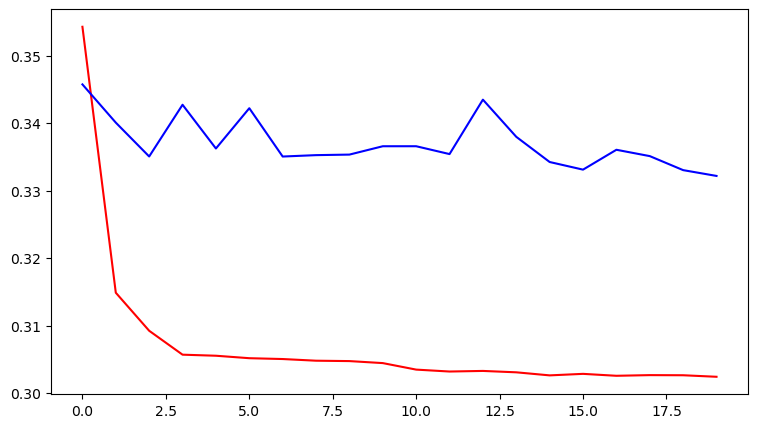

In [61]:
# Plot the loss function of the finalized log transformed ANN model
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(9,5))
ax.plot(history_logt.history['loss'], 'r', label='train')
ax.plot(history_logt.history['val_loss'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=16)
ax.set_ylabel(r'Loss (MSE)', fontsize=16)
ax.legend()
ax.tick_params(labelsize=14)

### After working through many modeling attempts, it is clear that log transforming the data yields the best possible models across all our differeing model types. The below plots compare these log transformed models.

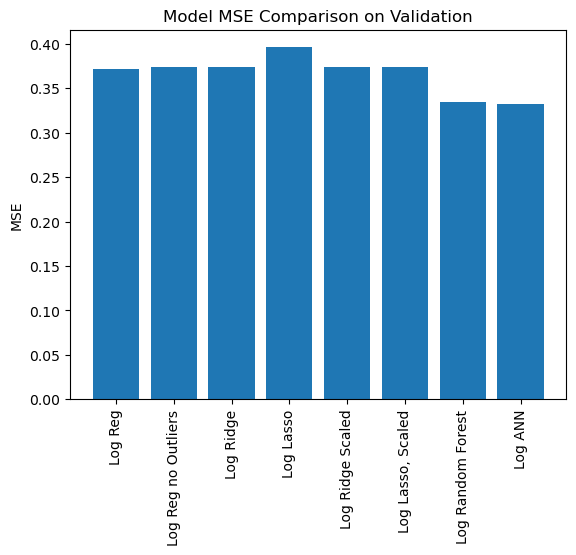

In [64]:
#import matplotlib.pyplot as plt

fig, ax = plt.subplots()

log_MSEs = [mse_logreg, mse_logreg_cooks, ridge_val_mse_non_scaled, lasso_val_mse_non_scaled, ridge_val_mse_scaled, 
            lasso_val_mse_scaled, rf_log_mse, ann_mse_logt]
model_labels = ['Log Reg', 'Log Reg no Outliers', 'Log Ridge', 'Log Lasso', 
               'Log Ridge Scaled', 'Log Lasso, Scaled', 'Log Random Forest', 'Log ANN']

ax.bar(model_labels ,log_MSEs, label=model_labels)

ax.set_ylabel('MSE')
ax.set_title('Model MSE Comparison on Validation')
plt.xticks(rotation=90)
plt.show()

### It appears our ANN model on log transformed data yields our best results for predicting median days on market, lets do one last look on the testing set. 

In [65]:
final_pred_ann_logt = best_model_logt.predict(test_set_x[[f'ln_{var}' for var in independent_vars]])

ann_mse_logt = mean_squared_error(np.log(test_set['median_days_on_market'] + 1), final_pred_ann_logt)
ann_r2_logt = r2_score(np.log(test_set['median_days_on_market'] + 1), final_pred_ann_logt)
print("Testing Data: Mean Square Error for vanilla ANN Model - log transformed data")
print(ann_mse_logt)
print("Testing Data: R2 for vanilla ANN Model - log transformed data")
print(ann_r2_logt)

12678/12678 [==============================] - 3s 243us/step
Testing Data: Mean Square Error for vanilla ANN Model - log transformed data
0.33219311112972666
Testing Data: R2 for vanilla ANN Model - log transformed data
0.37461590892373287


### One final model to look at is the most optimized Random Forest model. Now this takes many hours (6-7) to run, which is why it is exlcuded from the above Random Forest section. We will now try it on the log transformed data. 

In [51]:
#DO NOT RUN UNLESS PLANNING TO LET IT RUN FOR 6+hours 
# param_grid = {
#     'n_estimators': [50, 75, 125],
#     'max_depth': [5, 8, 12, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 3]
# }

# rf_opt = RandomForestRegressor(random_state=random.randint(1,100))
# grid_search = GridSearchCV(estimator=rf_opt, param_grid=param_grid, 
#                            cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')


# grid_search.fit(train_set_x[[f'ln_{var}' for var in independent_vars]], np.log(train_set['median_days_on_market'] + 1))


# print("Best Parameters:", grid_search.best_params_)

# best_model = grid_search.best_estimator_

# test_predictions = best_model.predict(test_set_x[[f'ln_{var}' for var in independent_vars]])


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=75; total time= 2.9min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 2.0min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 2.0min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=75; total time= 2.9min
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time= 2.0min
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=125; total time= 4.9min
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=125; total time= 4.9min
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=75; total time= 2.9min
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time= 1.9min
[CV] END max_depth=5, min_samples_leaf=3, 

[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 2.0min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 1.9min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=125; total time= 4.9min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=125; total time= 4.9min
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=75; total time= 2.9min
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time= 2.0min
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=75; total time= 2.9min
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=75; total time= 2.9min
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time= 1.9min
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=125; total time= 4.8min
[CV]

[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=75; total time= 2.9min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=75; total time= 3.0min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 1.9min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=125; total time= 4.9min
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=125; total time= 4.9min
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=75; total time= 2.9min
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time= 2.0min
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=125; total time= 4.9min
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=125; total time= 4.8min
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=75; total time= 4.5min
[CV

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 125}


In [73]:
#create best possible rf model based on the above code block

best_rf = RandomForestRegressor(max_depth = 15, min_samples_leaf = 2, min_samples_split = 10, n_estimators=125)

best_rf.fit(train_set_x[[f'ln_{var}' for var in independent_vars]], np.log(train_set['median_days_on_market'] + 1))

RandomForestRegressor(max_depth=15, min_samples_leaf=2, min_samples_split=10,
                      n_estimators=125)

### The best possible parameters identified for this optimized random forest model were: 
###  {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 125}
### Below we apply this model to the test set to compare with the results from the log transformed ann model

In [74]:
#add val/test R2 and MSE
val_predictions = best_rf.predict(val_set_x[[f'ln_{var}' for var in independent_vars]])

val_mse = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), val_predictions)
val_r2 = r2_score(np.log(validation_set['median_days_on_market'] + 1), val_predictions)

test_mse = mean_squared_error(np.log(test_set['median_days_on_market'] + 1), test_predictions)
test_r2 = r2_score(np.log(test_set['median_days_on_market'] + 1), test_predictions)

print("Validation MSE with Optimized Random Forest Model:", val_mse)
print("Validation R-squared with Optimized Random Forest Model:", val_r2)

print("Testing MSE with Optimized Random Forest Model:", test_mse)
print("Testing R-squared with Optimized Random Forest Model:", test_r2)

Validation MSE with Optimized Random Forest Model: 0.31741375863225296
Validation R-squared with Optimized Random Forest Model: 0.403677309732297
Testing MSE with Optimized Random Forest Model: 0.31745886334168866
Testing R-squared with Optimized Random Forest Model: 0.4023544858294299


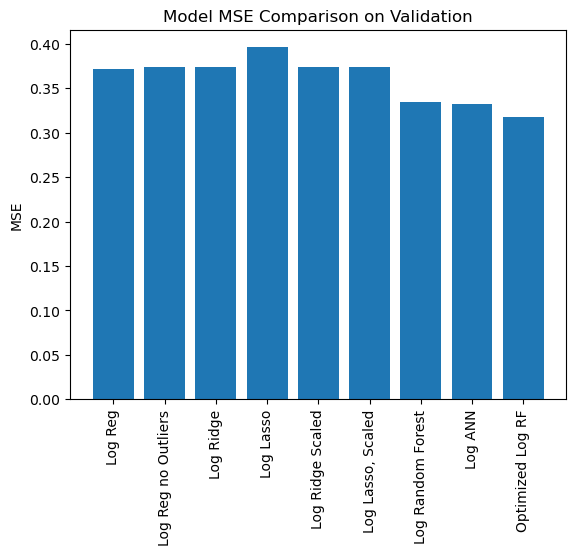

In [67]:
#final plot with opt RF
fig, ax = plt.subplots()

log_MSEs = [mse_logreg, mse_logreg_cooks, ridge_val_mse_non_scaled, lasso_val_mse_non_scaled, ridge_val_mse_scaled, 
            lasso_val_mse_scaled, rf_log_mse, ann_mse_logt, val_mse]
model_labels = ['Log Reg', 'Log Reg no Outliers', 'Log Ridge', 'Log Lasso', 
               'Log Ridge Scaled', 'Log Lasso, Scaled', 'Log Random Forest', 'Log ANN', 'Optimized Log RF']

ax.bar(model_labels ,log_MSEs, label=model_labels)

ax.set_ylabel('MSE')
ax.set_title('Model MSE Comparison on Validation')
plt.xticks(rotation=90)
plt.show()

### The optimized Random Forest regrssion model with the above parameters yields better results on the test set! The commented out line below will save the model locally if necessary.

In [ ]:
#best_model.save('optimized_rf_model')